In [24]:
import os
import sys

sys.path.append(".")  # Add the parent directory of LLM_Evaluations to the Python path
from statistics_plots_analysis_utils import *

def process_model_group(model_name, model_df, expert_group_df, questions_to_sum=None, group_num=None):
    model_group_df = model_df[model_df['Video ID'].isin(expert_group_df['Video ID'])].reset_index(drop=True)

    # Binarize scores for Group A
    if questions_to_sum and group_num == 1:
        for column in questions_to_sum:
            model_group_df[column] = model_group_df[column].apply(binarize_value)

    # Find total score, either selected columns for Group A, or all columns for Group B
    if questions_to_sum:
        model_group_df = sum_columns(model_group_df, questions_to_sum)

    # Merge expert and models scores, either total for gourp 1 and 2, or all scores for Group C
    columns_to_merge = ['Video ID'] + (['Model Total'] if questions_to_sum else MODEL_15_SCORE_COLUMNS)
    expert_group_df = merge_dataframes(expert_group_df, model_group_df, columns_to_merge)

    # Rename model score column to be as the model name; i.e. GPT-4 / Claude-3 / etc.
    if questions_to_sum:
        expert_group_df.rename(columns={'Model Total': model_name}, inplace=True)
    else:
        new_column_names = {f"Q{i}": f"{model_name} Q{i}" for i in range(1, 16)}
        expert_group_df.rename(columns=new_column_names, inplace=True)

    return expert_group_df

def plot_expert_model_agreements_barplot(group_df, model_names, labels, agreement_coef, topic_name, figsize=(15,6)):
    stats = {}
    col1 = 'Experts_Avg'
    for model_col in model_names:
        stats[model_col] = calculate_statistics(group_df, col1, model_col, labels)
    # Create DataFrame from the dictionary
    stat_group_df = pd.DataFrame.from_dict(stats).round(2)
    agreement_df = stat_group_df.loc[[agreement_coef]]

    values = agreement_df.values.flatten()
    columns = agreement_df.columns
    create_plot('bar', data=agreement_df,
                columns=columns, values=values,
                figsize=figsize, ylim=(min(0, min(values)), 1),
                xlabel='Models', ylabel=agreement_coef,
                title=f'Agreement between Expert and Model Ratings',
                # title=f'{topic_name}: Agreement between Expert and Model Ratings',
                xticks_rotation=45)

    return stat_group_df

def plot_models_agreement_heatmap(group_df: pd.DataFrame, model_names, labels, agreement_coef, topic_name, figsize=(13, 6)):
    models_agreement_df = pd.DataFrame(index=model_names[:-1], columns=model_names[1:], dtype=float)

    n = len(model_names)
    # Fill only the upper triangular part of the DataFrame with the 'Weighted Kappa' values
    for i in range(n):
        for j in range(i + 1, n):
            model1 = model_names[i]
            model2 = model_names[j]
            stat = calculate_statistics(group_df, model1, model2, labels)
            models_agreement_df.at[model1, model2] = stat.get(agreement_coef)

    create_plot('heatmap', data=models_agreement_df,
                figsize=figsize,
                title=f'Agreement between Models {(agreement_coef)} Heatmap',
                # title=f'{topic_name}: Agreement between Models {(agreement_coef)} Heatmap',
                xticks_rotation=90)
    
    return models_agreement_df

def model_agreements_gt_60per(models_agreement_df, topic_name, figsize=(10, 4)):

    # Stack the DataFrame to convert it into a Series
    stacked_df = models_agreement_df[models_agreement_df > 0.59].stack()

    # Sort the Series (which contains the values of the DataFrame) in descending order
    sorted_stacked_df = stacked_df.sort_values(ascending=False)

    # Convert the sorted Series back to a DataFrame
    sorted_models_agreement_df = sorted_stacked_df.unstack()

    # Optionally round the values to 2 decimal places again
    sorted_models_agreement_df = sorted_models_agreement_df.round(2)

    # Display the sorted DataFrame
    create_plot('heatmap', data=sorted_models_agreement_df,
                figsize=figsize,
                title=f'{topic_name}: Models Agreement (> 0.6) Heatmap',
                # title=f'{topic_name}: Models Agreement (> 0.6) Heatmap',
                xticks_rotation=90)

def plot_questionwise_agreement_heatmap(stat_group_df: pd.DataFrame, model_names, agreement_coef, topic_name, figsize=None):
    question_avg = stat_group_df.mean(axis=1).values.reshape(-1, 1).round(2)
    model_avg = stat_group_df.mean(axis=0).values.reshape(1, -1).round(2)

    if figsize is None:
        (m, n) = stat_group_df.shape
    else:
        (m, n) = figsize

    asp = 0.5 * m / float(n)
    figw = m - 1
    figh = figw * asp
    gridspec_kw = {'height_ratios': [m, 1], 'width_ratios': [n, 1]}
    fig, axes = plt.subplots(2, 2, figsize=(figw, figh), gridspec_kw=gridspec_kw)

    plt.subplots_adjust(top=0.90, wspace=0.05, hspace=0.1)

    hm_kwargs = dict(vmin=0, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, linecolor='black')

    # Plot stat_groupC_df heatmap
    sns.heatmap(stat_group_df, ax=axes[0, 0], xticklabels=False, cbar=False, **hm_kwargs)

    # Plot q_avg heatmap
    sns.heatmap(question_avg, ax=axes[0, 1], yticklabels=False, **hm_kwargs)
    axes[0, 1].set_xticklabels(['Question Avg'])

    # Plot model_avg heatmap
    sns.heatmap(model_avg, ax=axes[1, 0], cbar=False, **hm_kwargs)
    axes[1, 0].set_xticklabels(model_names, rotation=90)
    axes[1, 0].set_yticklabels(['Model Avg'])

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # plt.tight_layout()
    fig.suptitle(f'{topic_name}: Agreement {(agreement_coef)} Heatmap', fontsize=16)
    # fig.suptitle(f'{topic_name}: Agreement between Expert and Models (Weighted Kappa) Heatmap', fontsize=16)

    plt.show()

## Evaluate LLM Evaluation

Zero-Shot Prompting: 7 topics

In [2]:
model_names_and_files = {
    "BioMistral": "BioMistral-response.csv",
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-response.csv",
    "Falcon 40B": "falcon-40b-instruct-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-latest-response.csv",
    "GPT-4 Turbo": "gpt-4-turbo-response.csv",
    # "GPT-4o": "gpt-4o-last_3_topics-COT_prompting-response.csv",
    "KTO Mistral": "KTO_Mistral_PairRM-response.csv",
    "Llama-3 70B": "Llama-3-70B-Instruct-response.csv",
    "Llama-3 8B": "Llama-3-8B-Instruct-response user-only-prompt.csv",
    "Meerkat": "meerkat-response.csv",
    "Mistral 7B": "Mistral-7B-Instruct-response.csv",
    "Mixtral 8x22B": "Mixtral-8x22B-Instruct-response.csv",
    "Mixtral 8x7B": "Mixtral-8x7B-Instruct-response.csv",
    "MultiVerse 70B": "MultiVerse_70B-response.csv",
    "Orca-2": "Orca-2-do_sample=false-response.csv",
    "Phi-3 mini": "Phi-3-mini-4k-instruct-response.csv",
    "Qwen-1.5 72B": "Qwen1_5-72B-response.csv",
    "Rhea": "Rhea-response.csv",
    "Vicuna 33B": "vicuna-33b-response.csv",
    "Yi 34B": "Yi-34B-response.csv",
}

Zero-shot Prompting: ISA topic

In [33]:
model_names_and_files = {
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-diabetes-ZS_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-latest-diabetes-ZS_prompting-response.csv",
    "Gemini-1.5 Pro": "gemini-1.5-pro-latest-diabetes-ZS_prompting-response.csv",
    "GPT-4o": "gpt-4o-diabetes-ZS_prompting-response.csv",
}

Chain-of-Thought Prompting: last 3 topics

In [2]:
model_names_and_files = {
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-last_3_topics-COT_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-last_3_topics-COT_prompting-response.csv",
    "GPT-4o": "gpt-4o-last_3_topics-COT_prompting-response.csv",
}

Zero-shot: binary questions: first 2 topics

In [2]:
model_names_and_files = {
    # "Claude-3 Sonnet": "claude-3-sonnet-20240229-diabetes-zero_shot_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-first_2_topics-ZS_prompting-binary_questions-response.csv",
    "Gemini-1.5 Pro": "gemini-1.5-pro-latest-first_2_topics-ZS_prompting-binary_questions-response.csv",
    "GPT-4o": "gpt-4o-first_2_topics-ZS-binary_questions-response.csv",
}

### Prepare Three Groups

In [3]:
experts_file = "../../../Videos_and_DISCERN_data/filtered_experts_scores.csv"
# experts_file = "../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv"
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Split Expert DataFrame on Topic Groups

In [4]:
groupA_df = filter_df_by_topics(experts_df, TOPICS, ['NE', 'DE'], 
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupB_df = filter_df_by_topics(experts_df, TOPICS, ['ISA'], 
groupB_df = filter_df_by_topics(experts_df, TOPICS, ['SB', 'FF', 'CH', 'TF', 'PN'], 
# groupB_df = filter_df_by_topics(experts_df, TOPICS, ['PN'],
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupC_df = filter_df_by_topics(experts_df, TOPICS, ['PN'], 
groupC_df = filter_df_by_topics(experts_df, TOPICS, ['CH', 'TF', 'PN'], 
                                return_cols=experts_df.columns)
groupC_df = calculate_experts_avg_of_questions(groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)
# groupC_df = groupC_df[['Video ID', 'Topic', *[f"Experts_Avg Q{i}" for i in range(1, 16)]]]

print("Group A shape:", groupA_df.shape)
print("Group B shape:", groupB_df.shape)
print("Group C shape:", groupC_df.shape)

Group A shape: (82, 5)
Group B shape: (194, 5)
Group C shape: (133, 50)


#### Load LLM Scores

In [5]:
models_dir = "../../../Results/LLMs_Responses"
# model_files = [f for f in os.listdir(models_dir) if f.endswith('.csv')]
model_names = list(model_names_and_files.keys())

for model_name, model_file in model_names_and_files.items():
    # model_name = model_file.split('-response')[0]
    model_path = os.path.join(models_dir, model_file)
    model_df = pd.read_csv(model_path, encoding="utf-8", usecols=['Video ID'] + MODEL_15_SCORE_COLUMNS[:])

    groupA_df = process_model_group(model_name, model_df, groupA_df, 
                                            questions_to_sum=['Q1', 'Q4', 'Q6', 'Q7', 'Q8'],
                                            # questions_to_sum=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                                            group_num=1)
    
    groupB_df = process_model_group(model_name, model_df, groupB_df, 
                                            questions_to_sum=MODEL_15_SCORE_COLUMNS)
    
    groupC_df = process_model_group(model_name, model_df, groupC_df)
    
print("Group A shape:", groupA_df.shape)
groupA_df.head(2)

Group A shape: (82, 24)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,Claude-3 Sonnet,Falcon 40B,Gemini-1.0 Pro,GPT-4 Turbo,...,Mistral 7B,Mixtral 8x22B,Mixtral 8x7B,MultiVerse 70B,Orca-2,Phi-3 mini,Qwen-1.5 72B,Rhea,Vicuna 33B,Yi 34B
0,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,2.0,5,3,5,0,3,...,5,2,5,2,3,5,3,2,2,5
1,95T3ABnnhOs,Nocturnal Enuresis,1,1.0,1.0,4,2,5,1,3,...,3,2,4,2,5,4,3,2,4,5


In [6]:
print("Group B shape:", groupB_df.shape)
groupB_df.head(2)

Group B shape: (194, 24)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,Claude-3 Sonnet,Falcon 40B,Gemini-1.0 Pro,GPT-4 Turbo,...,Mistral 7B,Mixtral 8x22B,Mixtral 8x7B,MultiVerse 70B,Orca-2,Phi-3 mini,Qwen-1.5 72B,Rhea,Vicuna 33B,Yi 34B
0,t6PP67AsJaI,Spina Bifida,26,25.0,25.5,71,48,60,26.0,39,...,59.0,45,43,30,48,69,51,36,63,67
1,TuLAGDTpR6Y,Spina Bifida,32,33.0,32.5,73,53,65,46.0,50,...,72.0,44,62,46,61,72,63,54,71,75


In [7]:
print("Group C shape:", groupC_df.shape)
groupC_df.head(2)

Group C shape: (133, 335)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Yi 34B Q6,Yi 34B Q7,Yi 34B Q8,Yi 34B Q9,Yi 34B Q10,Yi 34B Q11,Yi 34B Q12,Yi 34B Q13,Yi 34B Q14,Yi 34B Q15
0,WHGCRT9xgu0,Cluster Headache,28,NaN,28.0,5.0,5.0,5.0,5.0,1.0,...,5,5,5,4,5,5,5,1,5,5
1,0Fe0m0IF6r8,Cluster Headache,30,NaN,30.0,5.0,5.0,5.0,5.0,1.0,...,2,1,4,2,4,2,5,1,4,2


### Group A Analysis
Group A: Scores out of 5. Experts individual scores are not provided

In [13]:
agreement_expert1_vs_expert2 = calculate_statistics(groupA_df, 'Expert1', 'Expert2')
print("Weighted Kappa agreement between Expert 1 and Expert 2:", agreement_expert1_vs_expert2['Weighted Kappa'].round(2))

Weighted Kappa agreement between Expert 1 and Expert 2: 0.92


Descriptive Statistics

In [14]:
groupA_df.drop(columns=['Expert1', 'Expert2'], inplace=True)
statA_df = groupA_df.describe().round(2).T
columns_to_convert_type = ['count', 'min', 'max']
statA_df[columns_to_convert_type] = statA_df[columns_to_convert_type].astype(int)
statA_df.rename_axis('Model', axis=1, inplace=True)
statA_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,82,1.32,0.55,1,1.0,1.0,1.88,4
BioMistral,82,2.85,1.76,0,1.0,3.0,5.00,5
Claude-3 Sonnet,82,2.10,1.05,0,1.0,2.0,3.00,4
Falcon 40B,82,4.88,0.48,2,5.0,5.0,5.00,5
Gemini-1.0 Pro,82,0.35,0.60,0,0.0,0.0,1.00,2
GPT-4 Turbo,82,1.59,1.07,0,1.0,2.0,2.00,4
KTO Mistral,82,2.45,1.19,0,2.0,3.0,3.00,5
Llama-3 70B,82,2.34,0.80,0,2.0,2.0,3.00,4
Llama-3 8B,82,3.12,1.18,1,2.0,3.0,4.00,5
Meerkat,82,3.65,1.29,0,3.0,4.0,5.00,5


Box Plot

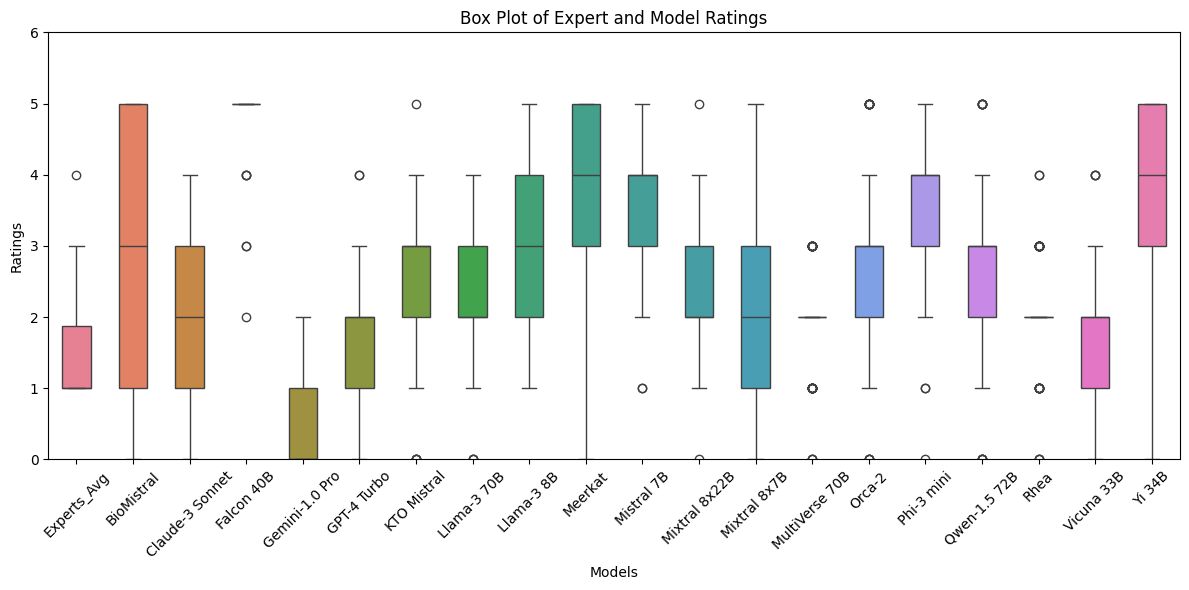

In [17]:
create_plot('boxplot', data=groupA_df,
            figsize=(12, 6), ylim=(0, 6),
            xlabel="Models", ylabel="Ratings",
            title="Box Plot of Expert and Model Ratings",
            xticks_rotation=45)

Bar Plot

Statistic,Gemini-1.0 Pro,Gemini-1.5 Pro,GPT-4o
Wilcoxon signed-rank test p-value,0.0,0.72,0.00
Weighted Kappa,0.1,0.25,0.15


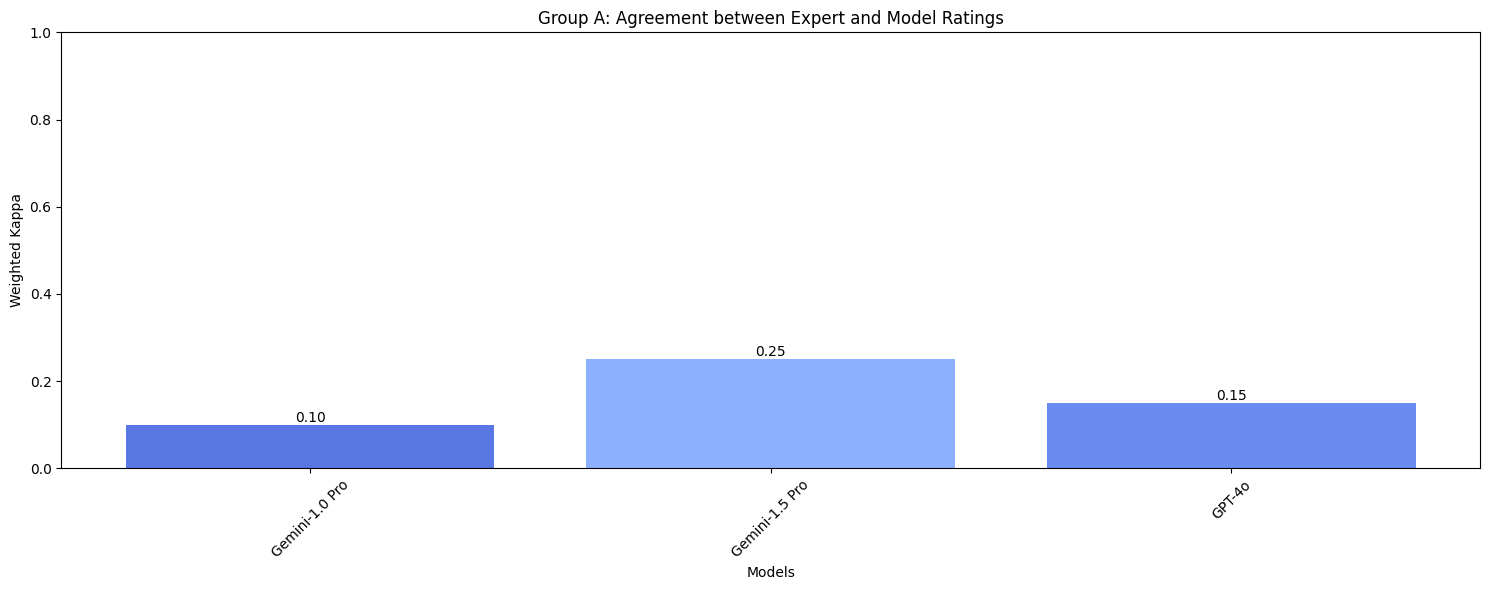

In [9]:
stat_groupA_df = plot_expert_model_agreements_barplot(groupA_df, model_names, 'Group A', figsize=(15,6))

stat_groupA_df.rename_axis('Statistic', axis=1, inplace=True)
stat_groupA_df

Similarity Statistics

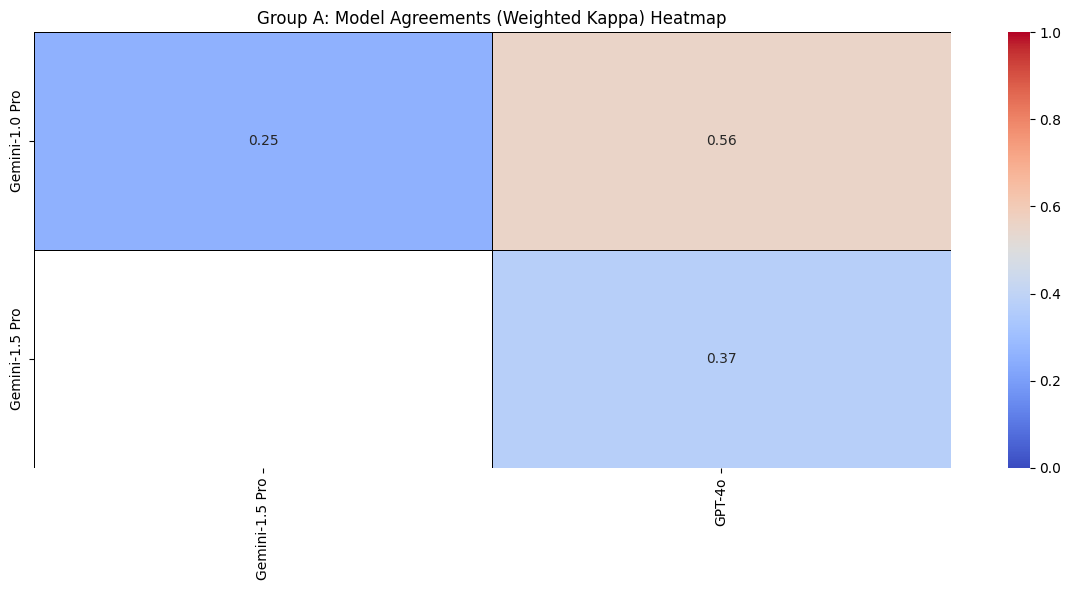

In [10]:
models_agreementA_df = plot_models_agreement_heatmap(groupA_df, model_names, topic_name='Group A', figsize=(12,6))

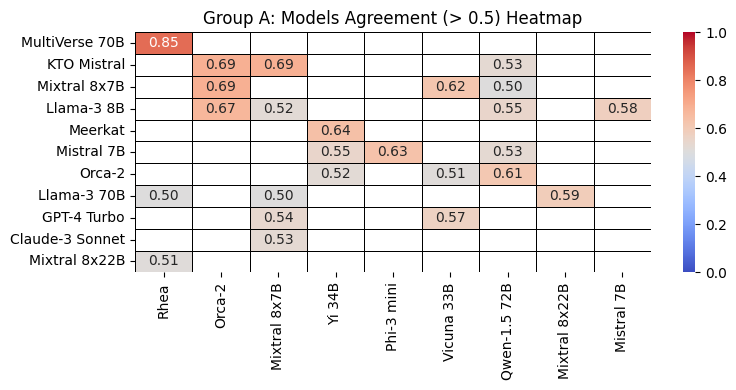

In [49]:
model_agreements_gt_60per(models_agreementA_df, topic_name='Group A', figsize=(8, 4))

### Group B Analysis
Group B: Total scores out of 75.

In [13]:
topic_name = 'Group B'

In [10]:
agreement_expert1_vs_expert2 = calculate_statistics(groupB_df, 'Expert1', 'Expert2', range(15,76))
print("Weighted Kappa agreement between Expert 1 and Expert 2:")
agreement_expert1_vs_expert2

Weighted Kappa agreement between Expert 1 and Expert 2:


{'Wilcoxon signed-rank test p-value': 0.7820701686110775,
 'Paired t-test p-value': 0.5729198978304675,
 'ICC3': 0.8836133758055769,
 'CCC': 0.8721615591541452,
 'Weighted Kappa': 0.8831963687311042}

#### Descriptive Statistics

In [11]:
groupB_df.drop(columns=['Expert1', 'Expert2'], inplace=True)
statB_df = groupB_df.describe().round(2).T
columns_to_convert_type = ['count', 'min', 'max']
statB_df[columns_to_convert_type] = statB_df[columns_to_convert_type].astype(int)
statB_df.rename_axis('Model', axis=1, inplace=True)
statB_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,194,31.58,10.96,11,24.50,30.0,39.00,72
BioMistral,194,52.65,11.17,19,45.00,52.0,59.75,75
Claude-3 Sonnet,194,49.13,9.73,20,44.00,49.0,55.00,72
Falcon 40B,194,59.86,8.72,15,60.00,60.0,60.00,75
Gemini-1.0 Pro,194,37.02,8.45,16,32.00,38.0,44.00,63
GPT-4 Turbo,194,44.31,8.20,20,39.00,44.5,50.00,63
KTO Mistral,194,52.05,14.80,15,43.00,54.5,62.00,75
Llama-3 70B,194,45.98,7.66,25,42.00,47.0,51.00,62
Llama-3 8B,194,48.30,9.26,21,42.25,50.0,56.00,64
Meerkat,194,66.26,11.12,19,63.25,71.0,75.00,75


In [ ]:
create_plot('boxplot', data=groupB_df,
            figsize=(10, 5), ylim=(0, 80),
            xlabel="Models", ylabel="Ratings",
            title=f'{topic_name}: Box Plot of Expert and Model Ratings',
            xticks_rotation=45)

Statistic,Wilcoxon signed-rank test p-value,Paired t-test p-value,ICC3,CCC,Weighted Kappa
BioMistral,0.0,0.0,0.12,0.04,0.03
Claude-3 Sonnet,0.0,0.0,0.41,0.17,0.14
Falcon 40B,0.0,0.0,-0.06,-0.01,-0.01
Gemini-1.0 Pro,0.0,0.0,0.45,0.39,0.36
GPT-4 Turbo,0.0,0.0,0.43,0.23,0.23
KTO Mistral,0.0,0.0,0.42,0.19,0.17
Llama-3 70B,0.0,0.0,0.42,0.20,0.18
Llama-3 8B,0.0,0.0,0.45,0.19,0.19
Meerkat,0.0,0.0,0.23,0.04,0.04
Mistral 7B,0.0,0.0,0.44,0.08,0.07


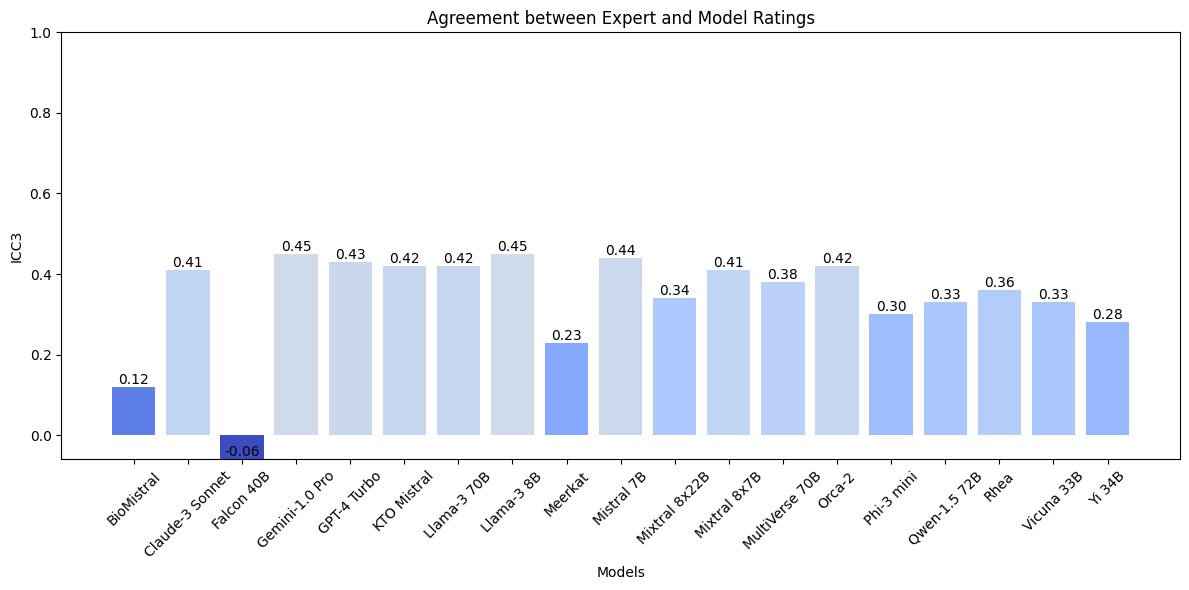

In [26]:
labels = range(15, 76)
# labels = range(1, 6)
stat_groupB_df = plot_expert_model_agreements_barplot(groupB_df, model_names, labels, 'ICC3', topic_name, figsize=(12,6))

stat_groupB_df.rename_axis('Statistic', axis=0, inplace=True)
stat_groupB_df.T

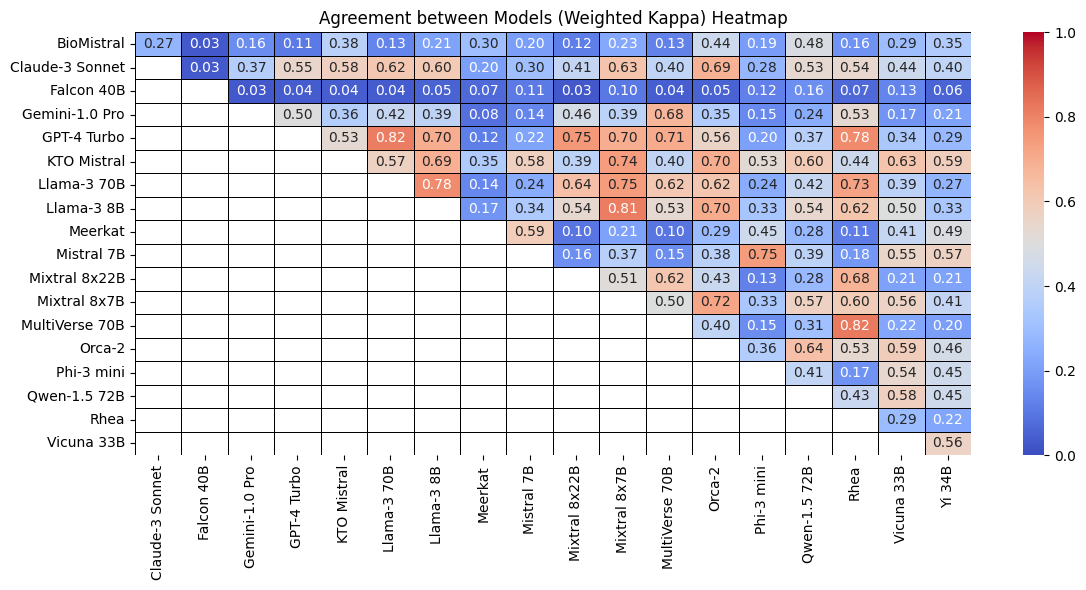

In [30]:
models_agreementB_df = plot_models_agreement_heatmap(groupB_df, model_names, topic_name, figsize=(12,6))

In [ ]:
model_agreements_gt_60per(models_agreementB_df, topic_name, figsize=(10, 5))

### Group C Analysis
Group C: individual 15 scores

In [ ]:
questionwise_agreement(groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS, 'Expert 1', 'Expert 2', topic_name, figsize= (6,5))

#### Descriptive Statistics

Box-plot

Similarity Statistics

In [13]:
stat_groupC_df = pd.DataFrame(index=MODEL_15_SCORE_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num in range(1, 16):
        expert_col = f"Experts_Avg Q{question_num}"
        model_col = f"{model_name} Q{question_num}"
        statistics = calculate_statistics(groupC_df, expert_col, model_col)
        stat_groupC_df.at[f"Q{question_num}", model_name] = round(statistics.get('Weighted Kappa'), 2)

# stat_groupC_df['Question Average'] = question_avg
# stat_groupC_df.loc['Model Average'] = model_avg

# create_plot('heatmap', data=stat_groupC_df,
#             figsize=(15, 6),
#             title='Group C Weighted Kappa Heatmap',
#             xticks_rotation=90)

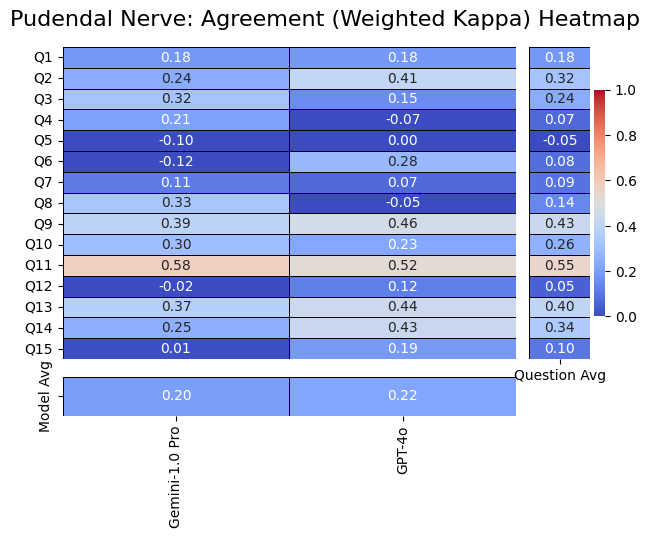

In [14]:
plot_questionwise_agreement_heatmap(stat_groupC_df, model_names, topic_name, figsize=(8,6))

In [ ]:
stat_groupC_filtered_df = stat_groupC_df.drop(
    columns=['BioMistral', 'Falcon 40B', 'Phi-3 mini', 'Meerkat', 'Mistral 7B', 'Yi 34B', 'Qwen-1.5 72B', 'Vicuna 33B'],
)

stat_groupC_filtered_df['Question Average'] = stat_groupC_filtered_df.mean(axis=1)
stat_groupC_filtered_df.loc['Model Average'] = stat_groupC_filtered_df.mean()

create_plot('heatmap', data=stat_groupC_filtered_df,
            figsize=(12, 5),
            title=f'{topic_name}: Agreement (Weighted Kappa) Heatmap for Selected Models',
            xticks_rotation=90)